<a href="https://colab.research.google.com/github/DevKor-Team/MRDC-Challenge/blob/lee/lee/version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!pip install --upgrade -q fastai

In [47]:
import os
import numpy as np
import pandas as pd
import re
from fastai.vision.all import *

In [48]:
BASE_DIR = "/content/drive/MyDrive/MRDC_data"
train = pd.read_csv(os.path.join(BASE_DIR, "Train.csv"))
test = pd.read_csv(os.path.join(BASE_DIR, "Test.csv"))

In [49]:
!mkdir -p images
!unzip -q /content/drive/MyDrive/MRDC_data/Images.zip -d images

replace images/id_004wknd7qd.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

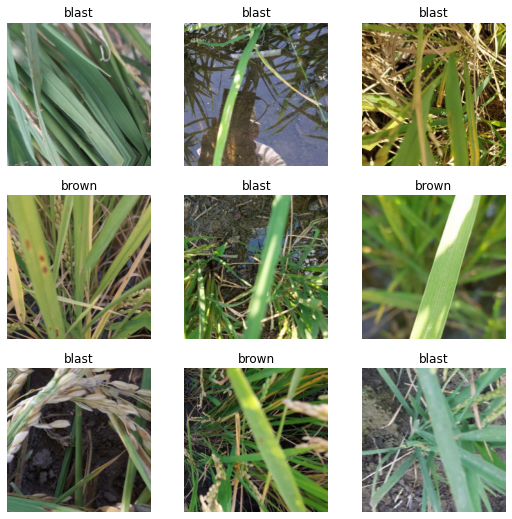

In [50]:
# Create the dataloaders
train_rgb = train[~train.Image_id.str.contains('_rgn')] # Just the RGB images
dls = ImageDataLoaders.from_df(train_rgb, fn_col='Image_id', label_col='Label', 
                               folder='images', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(size=224))
dls.show_batch() # Note the augmentation applied to the images!

In [51]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
test = test[~test.Image_id.str.contains('_rgn')] # Just the RGB images
preds, _ = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities
preds.shape

In [ ]:
learn.dls.vocab
preds[0]
submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:,i].numpy()
submission.head()
submission.to_csv('result.csv', index=False)

In [ ]:
!pip install wandb

epoch,train_loss,valid_loss,error_rate,time
0,1.391972,0.681394,0.245318,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.852231,0.591517,0.176030,00:18
1,0.681320,0.491962,0.144195,00:18
2,0.508614,0.369865,0.116105,00:18
3,0.397127,0.352991,0.121723,00:20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▃▁▁
lr_0,▁▂▃▄▅▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▄▅▆▇█▂▂▂▂▃▃▄▄▄▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
lr_2,▁▂▃▄▅▆▇█▂▂▂▂▃▃▄▄▄▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▄▃▂▁██▇▇▆▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇███
mom_1,██▇▆▄▃▂▁██▇▇▆▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇███
mom_2,██▇▆▄▃▂▁██▇▇▆▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇███


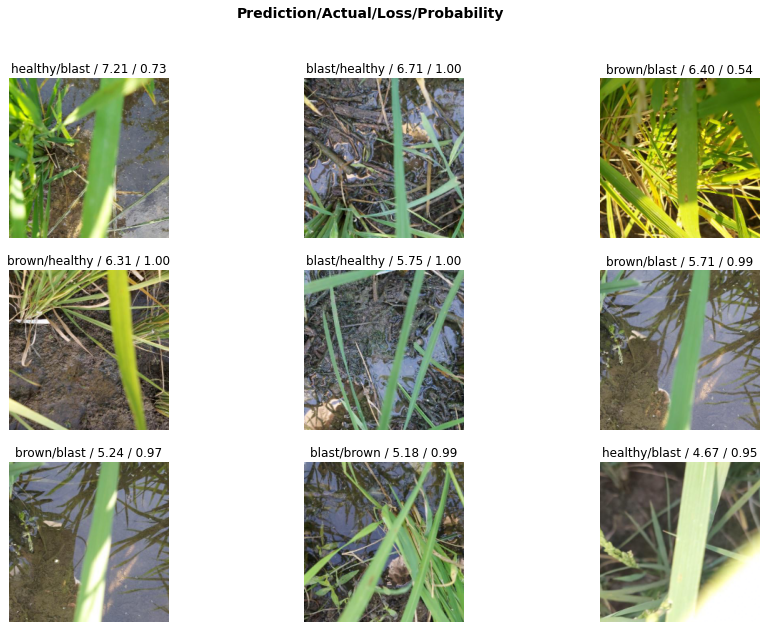

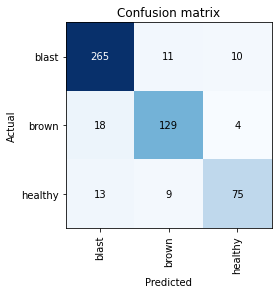

In [52]:
# Import the callbacks that add wandb integration to fastai
from fastai.callback.wandb import *

# Initialize W&B
wandb.init(project='rice_challenge',name='hello',
    config={   
        # Store any relevant parameteres here:
        'Description':'Resnet34 baseline',
        'Image size':224
    }, 
)

# Create the dataloaders:
dls = ImageDataLoaders.from_df(train_rgb, fn_col='Image_id', label_col='Label',
                               folder='images', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(size=224))

# Create our learner
learn = vision_learner(dls, resnet34, metrics=error_rate,
                       cbs=WandbCallback()) # << Note the callback

# Train
learn.fine_tune(4)

# Store some extra plots (optional):
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))
plt.savefig('top_losses.png')
wandb.log({'Top losses':wandb.Image('top_losses.png')})
interp.plot_confusion_matrix()
plt.savefig('cm.png')
wandb.log({'Confusion matrix':wandb.Image('cm.png')})

# End the run
wandb.finish() 